In [1]:
# taken from https://github.com/datapythonista/mnist/blob/master/mnist/__init__.py
import os
import functools
import operator
import struct
import array
import tempfile

def parse_idx(fd):
    """Parse an IDX file, and return it as an array of arrays.
    
    Parameters
    ----------
    fd : file
        File descriptor of the IDX file to parse
    endian : str
        Byte order of the IDX file. See [1] for available options
    Returns
    -------
    data : array
        Numpy array with the dimensions and the data in the IDX file
    1. https://docs.python.org/3/library/struct.html
        #byte-order-size-and-alignment
    """
    DATA_TYPES = {0x08: 'B',  # unsigned byte
                  0x09: 'b',  # signed byte
                  0x0b: 'h',  # short (2 bytes)
                  0x0c: 'i',  # int (4 bytes)
                  0x0d: 'f',  # float (4 bytes)
                  0x0e: 'd'}  # double (8 bytes)

    header = fd.read(4)
    if len(header) != 4:
        raise IdxDecodeError('Invalid IDX file, '
                             'file empty or does not contain a full header.')

    zeros, data_type, num_dimensions = struct.unpack('>HBB', header)

    if zeros != 0:
        raise IdxDecodeError('Invalid IDX file, '
                             'file must start with two zero bytes. '
                             'Found 0x%02x' % zeros)

    try:
        data_type = DATA_TYPES[data_type]
    except KeyError:
        raise IdxDecodeError('Unknown data type '
                             '0x%02x in IDX file' % data_type)

    dimension_sizes = struct.unpack('>' + 'I' * num_dimensions,
                                    fd.read(4 * num_dimensions))

    data = array.array(data_type, fd.read())
    data.byteswap()  # looks like array.array reads data as little endian

    expected_items = functools.reduce(operator.mul, dimension_sizes)
    if len(data) != expected_items:
        raise IdxDecodeError('IDX file has wrong number of items. '
                             'Expected: %d. Found: %d' % (expected_items,
                                                          len(data)))
    return data

In [13]:
from urllib.request import urlretrieve
from pathlib import Path
import os, pickle, gzip, torch
from numba import njit
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

In [3]:
torch.set_printoptions(precision=3, linewidth=100)

In [4]:
data_url = 'https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/'
path = Path('./data/fashion_mnist')
if not path.exists(): path.mkdir()

filepaths = [path/'fashion_train.pkl.gz', path/'fashion_train_labels.pkl.gz', 
             path/'fashion_test.pkl.gz', path/'fashion_test_labels.pkl.gz']
filenames = ['train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz', 
             't10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz']
for i in range(4):
    if not filepaths[i].exists():
        urlretrieve(f'{data_url}{filenames[i]}', filepaths[i])

In [5]:
def chunks(l, sz):
    for i in range(0, len(l), sz):
        yield l[i:i+sz]

In [6]:
with gzip.open(filepaths[0], 'rb') as f: 
    X_train = list(iter(chunks(list(parse_idx(f)), 784)))
with gzip.open(filepaths[1], 'rb') as f: 
    y_train = list(parse_idx(f))
with gzip.open(filepaths[2], 'rb') as f: 
    X_valid = list(iter(chunks(list(parse_idx(f)), 784)))
with gzip.open(filepaths[3], 'rb') as f: 
    y_valid = list(parse_idx(f))

<br>**Save the data in csv format**

In [15]:
train_df = pd.DataFrame(columns = ['label'] + [f'pix_{i}' for i in range(784)])

In [25]:
train_df = pd.concat([pd.DataFrame(y_train, columns=['label']), 
                      pd.DataFrame(X_train, columns=[f'pix_{i}' for i in range(784)])], 
                      axis=1)

In [27]:
test_df = pd.concat([pd.DataFrame(y_valid, columns=['label']), 
                      pd.DataFrame(X_valid, columns=[f'pix_{i}' for i in range(784)])], 
                      axis=1)

In [36]:
train_df.to_csv('data/fashion_mnist/train.csv')
test_df.to_csv('data/fashion_mnist/test.csv')

<br><br>

In [43]:
X_train = (torch.tensor(X_train).float()/255.).view(-1, 28, 28)

/tmp/ipykernel_523/1639392555.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = (torch.tensor(X_train).float()/255.).view(-1, 28, 28)


In [57]:
y_train = torch.tensor(y_train)

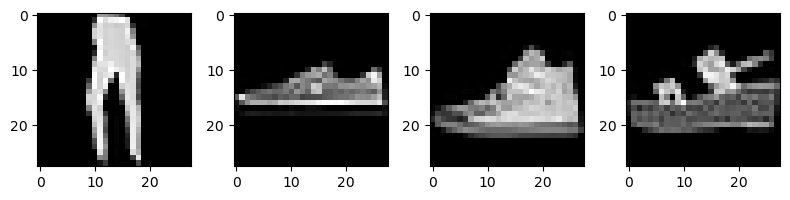

In [72]:
fig, ax = plt.subplots(1, 4, figsize=(8, 2))
ax[0].imshow(X_train[146], cmap='gray')
ax[1].imshow(X_train[14], cmap='gray')
ax[2].imshow(X_train[142], cmap='gray')
ax[3].imshow(X_train[12], cmap='gray')
plt.tight_layout()

In [74]:
y_train[142], y_train[14]

(tensor(7), tensor(7))

In [176]:
a = X_train[:5].view(-1, 784)
b = torch.randn(10, 784)

In [202]:
#@njit
def dott(a, b):
    return (a * b).sum(axis=1)

In [203]:
def matmul(a, b):
    res = torch.zeros(a.shape[0], b.shape[0])
    for a_row in range(a.shape[0]):
        res[a_row, :] = torch.tensor(dott(a[a_row, None], b))
    return res

In [205]:
%timeit -n 10 matmul(a.numpy(), b.numpy())

268 µs ± 114 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [185]:
res

tensor([[  5.274, -17.956, -29.311,  -9.783, -11.938,   9.562,   7.392,  23.109, -13.251,  22.076],
        [ -0.953,  -7.734, -14.233,  -0.742, -23.998,  21.311,  22.677,  27.095,  12.998,  -3.242],
        [  0.034,   0.605,  -7.732,  -2.127,  -8.450,  12.408,   3.856,   6.317,   5.109,   3.092],
        [ -3.030, -14.136, -13.192, -10.020,  -4.484,  16.212,   4.962,  13.871,  10.524,  12.059],
        [ -1.158,  -5.744, -19.946,  -9.635, -21.402,  21.871,  -4.341,  22.201,   8.888,   6.362]])

<br><br>

In [3]:
a = torch.rand(100, 20)
b = torch.randn(20, 256)

In [16]:
res = torch.einsum('ij,jk->ik', a, b)

In [17]:
res

tensor([[-0.069, -1.840, -3.844,  ...,  1.044,  1.117, -0.688],
        [ 1.965, -1.411, -4.161,  ...,  1.722,  0.890, -2.254],
        [ 1.887, -0.979, -3.959,  ...,  0.350,  1.437, -0.290],
        ...,
        [-1.636, -1.790, -4.870,  ..., -1.367, -4.176, -0.533],
        [ 1.993, -4.537, -0.823,  ...,  1.024,  0.129, -2.312],
        [-3.295,  0.539, -6.113,  ...,  1.275, -2.501,  2.644]])